<a href="https://colab.research.google.com/github/ishantinsights/RCA/blob/main/Root_Cause_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Company has received some complaints from their customers facing problems related to ride cancellations by the driver and non-availability of cars
for a specific route in the city.

The uneven supply-demand gap for cabs from City to Airport and vice-versa is causing a bad effect on customer relationships as well as company is
losing out on its revenue.

The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to tackle the
situation.

Before jumping on to solution ,Let us clarify few of the things:


1. What is ride cancellation as per company?

Ride cancellation rate = No of cancelled bookings / No of confirmed bookings

Categorise the ride cancellations into two groups -
1. Intercity
2. City to Airport (or vice-versa)


<font color=orange>First of all, irrespective of the data that we have, there are some questions that we need to ask as a Data/Product Analyst to get some clarity on
the issue

Q.Is this thing happening for specific devices? (Android or iOS)

Q. Has there been any major change/upgrade in the product?

Q. Is this increase in cancellation rate gradual or sudden?'

Q. Have we checked for any issues on the driver app?

Q. Are we receiving any major complaints or bug reports?

Q. Is the change observed across several regions specifically or is it uniform?

Q. Are we seeing a high cancellation rate for driver’s belonging to a specific age group?

Q. Any pattern in ride cancellations in terms of the vehicle category? (Auto, Mini or Sedan)

Q. Has there been any major holiday in the past week?

Q. Have we done any recent experiments related to the platform?

Q. Has there been any recent strike or protest by the drivers?

Q. Has company been involved in any controversy lately?

Q. Are we currently facing any connectivity related issues throughout the region?
Q. Do we have any reports of frequent app crashes or something like that?

Q. Is there any change detected in the usual user behavior over the last week?

Q. Is it possible that the drivers might be using some other ride sharing platforms as well?





<font color=orange>Things we will be looking at:

- Frequency of booking requests getting cancelled each hour.
- Pickup & Destination of the cancelled booking requests.
- Days of week in which the cancellation rate is maximum.
- Time of day during which the cancellation rate is at peak.
- Time of day when the demand is highest and supply is low.
- Time of day when the cabs are available but demand is low.

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving uber-data.csv to uber-data.csv


In [ ]:
# Loading the dataset
df=pd.read_csv("/content/uber-data.csv",dayfirst=True)
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


In [ ]:
pd.to_datetime(df['Request timestamp'],format="%d/%m/%Y %H:%M",errors='coerce')

0      2016-07-11 11:51:00
1      2016-07-11 17:57:00
2      2016-07-12 09:17:00
3      2016-07-12 21:08:00
4                      NaT
               ...        
6740                   NaT
6741                   NaT
6742                   NaT
6743                   NaT
6744                   NaT
Name: Request timestamp, Length: 6745, dtype: datetime64[ns]

In [ ]:
pd.to_datetime(df['Request timestamp'],format="%d-%m-%Y %H:%M:%S",errors='coerce')

0                      NaT
1                      NaT
2                      NaT
3                      NaT
4      2016-07-13 08:33:16
               ...        
6740   2016-07-15 23:49:03
6741   2016-07-15 23:50:05
6742   2016-07-15 23:52:06
6743   2016-07-15 23:54:39
6744   2016-07-15 23:55:03
Name: Request timestamp, Length: 6745, dtype: datetime64[ns]

In [ ]:
# for enteries which are not of datetime format the output will be NAT(not a time) we use errors="coerce
# we combine both the formats
df['request_timestamp']=pd.to_datetime(df['Request timestamp'],format="%d-%m-%Y %H:%M:%S",errors='coerce').combine_first(pd.to_datetime(df['Request timestamp'],format="%d/%m/%Y %H:%M",errors='coerce'))

In [ ]:
# same treatment done for drop timestamp
df['drop_timestamp']=pd.to_datetime(df['Drop timestamp'],format="%d-%m-%Y %H:%M:%S",errors='coerce').combine_first(pd.to_datetime(df['Drop timestamp'],format="%d/%m/%Y %H:%M",errors='coerce'))

In [ ]:
# dropping repeat columns
df.drop(columns=['Request timestamp','Drop timestamp'],axis=1,inplace=True)

In [ ]:
# Checking for null values
df.isna().sum()/len(df)*100

Request id            0.000000
Pickup point          0.000000
Driver id            39.288362
Status                0.000000
request_timestamp     0.000000
drop_timestamp       58.028169
dtype: float64

--May be 58% of the times we don't have any cabs available or there are ride cancellations

-- Also the above data gives insight that 39% of the times there is no cab available

--this also suggest that there might be 19% cancellations (58-39)

In [ ]:
df['Status'].value_counts(normalize=True)

Status
Trip Completed       0.419718
No Cars Available    0.392884
Cancelled            0.187398
Name: proportion, dtype: float64

In [ ]:
# Checking for duplicate rows
df.duplicated().sum()

0

Feature Engineering

In [ ]:
def status(x):
  if x=="Trip Completed":
    return 'Available'
  else:
    return "Not Available"


df["Cab Availability"]=df['Status'].apply(status)

In [ ]:
# Extract hour from the Request timestamp
df['request_hour']=df['request_timestamp'].dt.hour

In [ ]:
# Separate 5 different time slots from the hour - Dawn  early morning  noon late evening night
def timeslot(x):
  if x<=4:
    return "Dawn"
  elif x<=9:
    return "Early Morning"
  elif x<=16:
    return "Noon"
  elif x<=21:
    return "Late Evening"
  else:
    return "Night"

df['timeslot']=df['request_hour'].apply(timeslot)


In Depth EDA

<Axes: ylabel='count'>

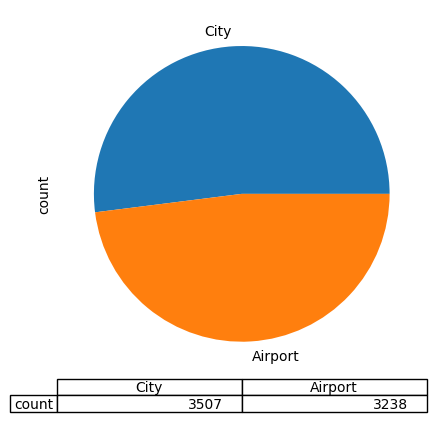

In [ ]:
# Types of Requests (city-airport or airport-city)
df['Pickup point'].value_counts().plot(kind='pie',table=True)

<Axes: xlabel='request_hour', ylabel='count'>

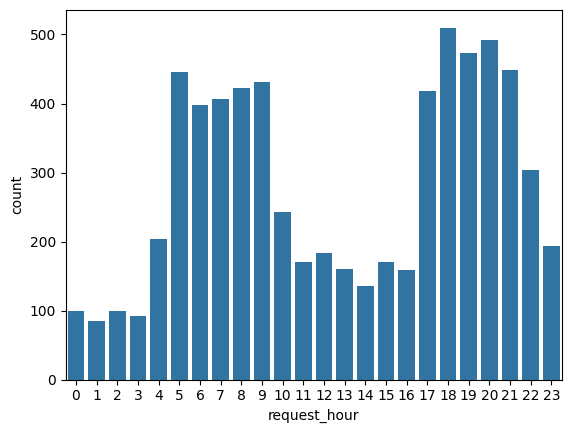

In [ ]:
sns.countplot(data=df,x='request_hour') # no of requests being raised with respect to

Peak hours: 5 am to 9am and 5pm to 9pm

<Axes: ylabel='count'>

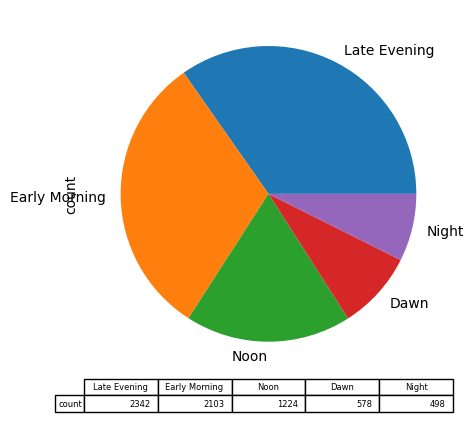

In [ ]:
#Distribution of Time Slots
df['timeslot'].value_counts().plot(kind='pie',table=True)

Observation:

Late Evenings and Early Mornings are not recommended for Airport-City transport or vice versa.


<Axes: xlabel='request_hour'>

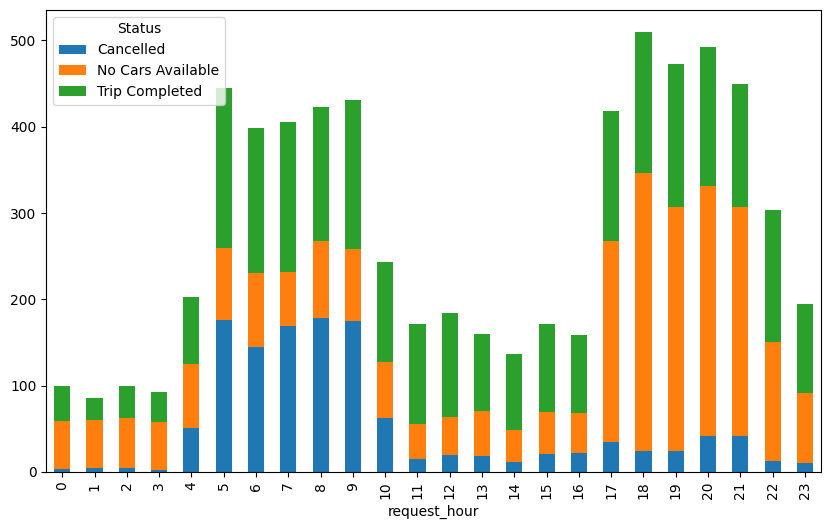

In [ ]:
#What is the Frequency of Requests that get Canceled or show ‘No Cars Available’ in each hour?

df.groupby('request_hour')['Status'].value_counts().unstack().plot(kind='bar',figsize=[10,6],stacked=True)

<Axes: xlabel='timeslot'>

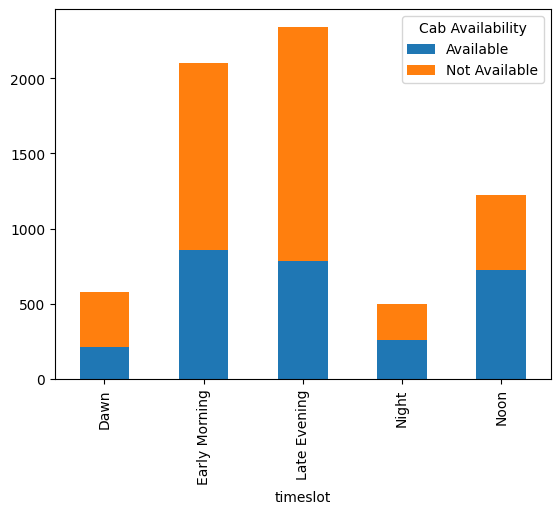

In [ ]:
#What are the Time Slots where the highest gap exists?

df.groupby(['timeslot'])['Cab Availability'].value_counts().unstack().plot(kind='bar',stacked=True)

Observation:

Among the assumed time slots, we can see that the Late Evening and Early Morning time slots has got the highest gap.
This means that during evening & morning hours the probability of getting a cab is very less

In [ ]:
# we have 2 types of trip and other is city to airport
air_df=df[df['Pickup point']=="Airport"]
city_df=df[df['Pickup point']=="City"]



<Axes: xlabel='request_hour'>

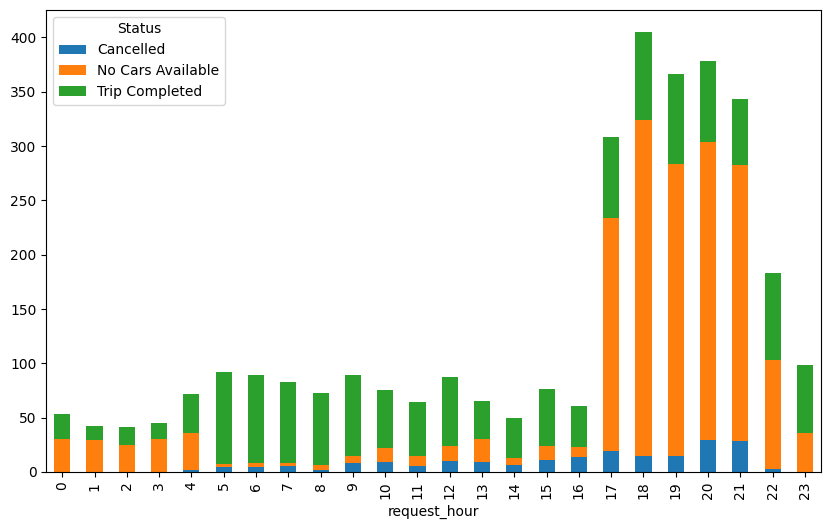

In [ ]:
#Plot the Demand-Supply Gap from Airport to City.

air_df.groupby('request_hour')['Status'].value_counts().unstack().plot(kind='bar',figsize=[10,6],stacked=True)

Observation:

There is very high demand for cabs from Airport to City between 5:00 PM – 9:00 PM
.
But the supply is very less due primarily due to 'No Cabs Available'

<Axes: xlabel='request_hour'>

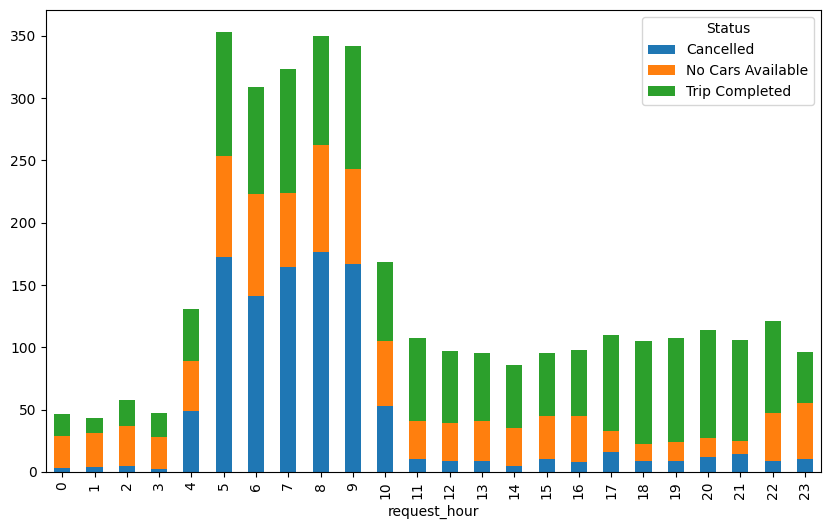

In [ ]:
# Plot the Demand-Supply Gap from City to Airport.

city_df.groupby('request_hour')['Status'].value_counts().unstack().plot(kind='bar',figsize=[10,6],stacked=True)

Observation:
There is very high demand for cabs from City to Airport between 5:00 AM – 9:00 AM
.But the supply is very less primarily due to Ride Cancellations


<Font color=orange>Root Cause: Drivers are not accepting the rides from city to airport because they might not get the return from airport and they might have to wait or return empty handed.
Due to this there is major unavailbility of cabs in the late evening hours at the airport

<font color=orange>Reasons for supply demand gap

1.In the Supply-Demand graph from Airport to City, between 5:00 PM to 9:00 PM there is very high demand for cabs because the supply is very low due to ‘No Cars Available’.

2.The ‘No Cars Available’ is due to the fact that in the previous hours fewer people travelled from City – Airport and so fewer cars are available in near Airport.

3.Likewise, in Supply-Demand graph from City – Airport, between 5:00 AM to 9:00 AM, there is very high demand for cabs because the supply is very low due to Ride Cancellations.

4.This is because there were fewer trips to Airport that completed in the previous hours, so now the cabs have to come from a long distance (City) to pickup the passenger and then they have to wait for the passenger’s arrival, so the drivers cancel the trip.

<font color=orange>Recommendations:

-- Increase the airport to city and city to airport tariff

-- Set up hubs for drivers at the airports with proper facilities where they can wait if they don't get a return ride
